In [4]:
import os
import cv2
import pickle
from PIL import Image as im
import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
np.random.seed(22)
#from tf.keras.model import save,load_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Activation, Flatten, BatchNormalization


In [2]:
def print_image(path: list, img_dir:str, label:str, num_pics=2):
    if num_pics > 1:
        fig, ax = plt.subplots(1, num_pics, sharex=True)
        plt.tight_layout()
        ax = ax.ravel()
        for idx, pth in enumerate(path[:num_pics]):
            ax[idx].imshow(plt.imread(pth), cmap='gray')
        fig.suptitle('Dataset: {}, Label: {}'.format(img_dir, label))
    elif num_pics == 1:
        plt.imshow(plt.imread(path[:num_pics][0]), cmap='gray')
        plt.title('Dataset: {}, Label: {}'.format(img_dir, label))
        plt.figure()
        

In [3]:
#Putting the path of all images in respective train,test,val directories

TRAIN_normal = 'data/chest_xray/train/NORMAL/'
TRAIN_normal_list = []
for x in os.listdir(TRAIN_normal):
    TRAIN_normal_list.append(os.path.join(TRAIN_normal,x))

TRAIN_pneumonia = 'data/chest_xray/train/PNEUMONIA/'
TRAIN_pneumonia_list = []
for x in os.listdir(TRAIN_pneumonia):
    TRAIN_pneumonia_list.append(os.path.join(TRAIN_pneumonia,x))

    
TEST_normal = 'data/chest_xray/test/NORMAL/'
TEST_normal_list = []
for x in os.listdir(TEST_normal):
    TEST_normal_list.append(os.path.join(TEST_normal,x))
    
TEST_pneumonia = 'data/chest_xray/test/PNEUMONIA/'
TEST_pneumonia_list = []
for x in os.listdir(TEST_pneumonia):
    TEST_pneumonia_list.append(os.path.join(TEST_pneumonia,x))


VAL_normal = 'data/chest_xray/val/NORMAL/'
VAL_normal_list = []
for x in os.listdir(VAL_normal):
    VAL_normal_list.append(os.path.join(VAL_normal,x))

VAL_pneumonia = 'data/chest_xray/val/PNEUMONIA/'
VAL_pneumonia_list = []
for x in os.listdir(VAL_pneumonia):
    VAL_pneumonia_list.append(os.path.join(VAL_pneumonia,x))



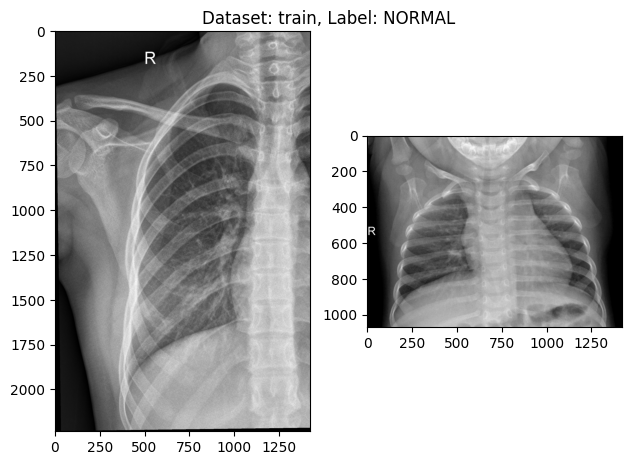

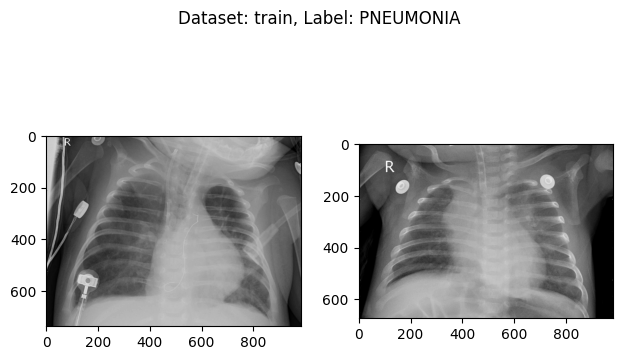

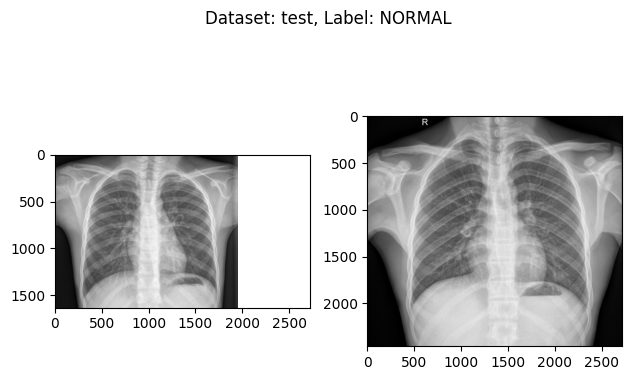

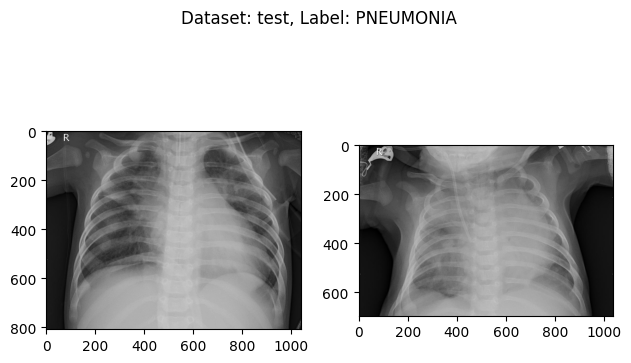

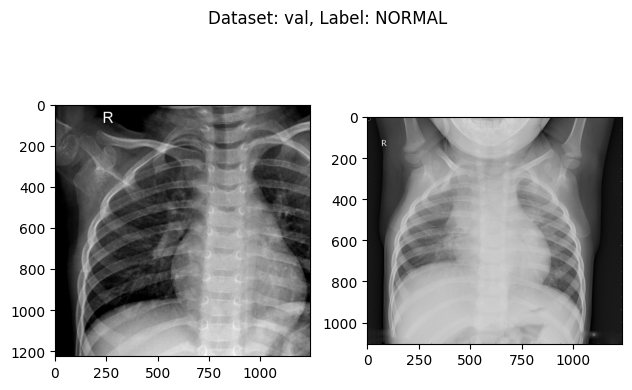

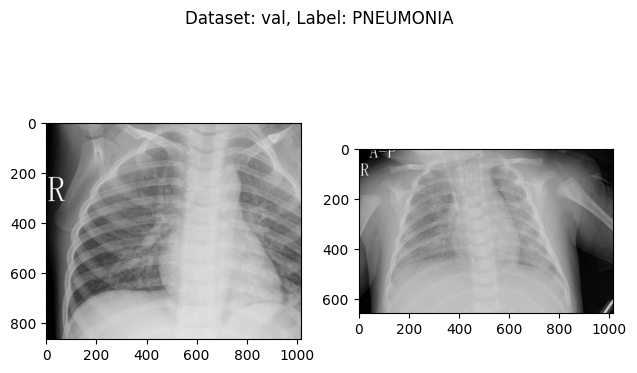

In [4]:
#Printing individual images from each train,test,val directories for each of NORMAL and PNEUMONIA
print_image(path = TRAIN_normal_list, img_dir = 'train', label='NORMAL')
print_image(path = TRAIN_pneumonia_list, img_dir = 'train', label='PNEUMONIA')

print_image(path = TEST_normal_list, img_dir = 'test', label='NORMAL')
print_image(path = TEST_pneumonia_list, img_dir = 'test', label='PNEUMONIA')

print_image(path = VAL_normal_list, img_dir = 'val', label='NORMAL')
print_image(path = VAL_pneumonia_list, img_dir = 'val', label='PNEUMONIA')


The total number of images in the dataset are: 5856

The breakup for each individual folder is: 
TRAIN_normal: contains 1341 images
TRAIN_pneumonia: contains 3875 images
TEST_normal: contains 234 images
TEST_pneumonia: contains 390 images
VAL_normal: contains 8 images
VAL_pneumonia: contains 8 images


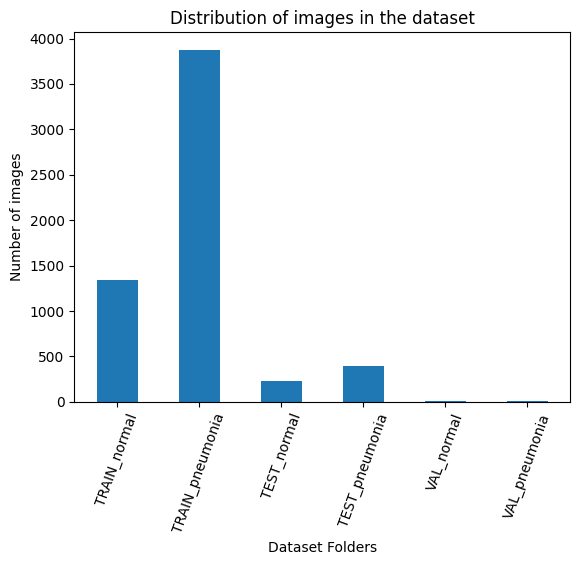

In [5]:
dataset_dict = {
    "TRAIN_normal":TRAIN_normal_list,
    "TRAIN_pneumonia":TRAIN_pneumonia_list,
    "TEST_normal":TEST_normal_list,
    "TEST_pneumonia":TEST_pneumonia_list,
    "VAL_normal":VAL_normal_list,
    "VAL_pneumonia":VAL_pneumonia_list
    }

dataset_folders = ["TRAIN_normal","TRAIN_pneumonia","TEST_normal","TEST_pneumonia","VAL_normal","VAL_pneumonia"]
def len_dataset_folders(folders:list, dataset_dict:dict):
    len_dataset = []
    for x in folders:
        len_dataset.append(len(dataset_dict[x]))
    return len_dataset

len_dataset = len_dataset_folders(dataset_folders,dataset_dict)
sum = 0
for i in len_dataset:
    sum = sum + i
print("The total number of images in the dataset are: {}".format(sum))
print()
print("The breakup for each individual folder is: ")

#printing the len of each folder in the dataset
for x, f in enumerate(dataset_dict):
    print('{}: contains {} images'.format(dataset_folders[x], len_dataset[x]))

%matplotlib inline    
#Bar Graph to show length of each folder in the dataset
plt.bar(dataset_folders, len_dataset, width = 0.5, align = 'center')
plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams["figure.figsize"] = (7,5)
plt.xticks(rotation=70)
plt.xlabel('Dataset Folders')
plt.ylabel('Number of images')
plt.title("Distribution of images in the dataset")
plt.show()


In [6]:
#Function for image pre-processing
def transform_dataset(normal_path:str, pneumonia_path:str):
    # Routine to convert and return the X and y datasets as np.ndarrays after some preprocessing
    X, y = [], []
    for img in tqdm(glob.glob(os.path.join(normal_path,'*.jpeg'))):
        img = cv2.imread(str(img))
        # Transform each stock image into a 224x224 RGB image and 
        # then into a vector of the same size but normalized between 0 and 1
        img = cv2.resize(img, (224,224))
        if img.shape[2] ==1:
            img = np.dstack([img, img, img])
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.astype(np.float32)/255.
        X.append(img)

    initial = len(X)
    # Target labels -> 1 = Pneumonia, 0 = Normal
    y_a = np.zeros(initial)

    for img in tqdm(glob.glob(os.path.join(pneumonia_path,'*.jpeg'))):
        img = cv2.imread(str(img))
        img = cv2.resize(img, (224,224))
        if img.shape[2] ==1:
            img = np.dstack([img, img, img])
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.astype(np.float32)/255.
        X.append(img)

    final = len(X)
    y = np.concatenate((y_a, np.ones(final-initial)))
    y = np.reshape(y, (y.shape[0],1))
    X = np.array(X)
    return X, y




In [7]:
X_train, y_train = transform_dataset(normal_path=TRAIN_normal, pneumonia_path=TRAIN_pneumonia)
X_test, y_test = transform_dataset(normal_path=TEST_normal, pneumonia_path=TEST_pneumonia)
X_val, y_val = transform_dataset(normal_path=VAL_normal, pneumonia_path=VAL_pneumonia)

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 236.48it/s]


In [8]:
print('Data augmentation for Training')
datagen_train = ImageDataGenerator(
        rotation_range = 10, 
        shear_range=0.2,
        zoom_range = 0.1, 
        width_shift_range = 0.1,
        horizontal_flip=True,
        height_shift_range = 0.1)
#X_train = X_train.reshape(5216, 224, 224,1)
datagen_train.fit(X_train)
train_gen = datagen_train.flow(X_train, y_train, batch_size = 32)

#test,tesa = next(train_gen)
print('Data Augmention for Validation')
datagen_val = ImageDataGenerator(
        rotation_range = 10, 
        shear_range=0.2,
        zoom_range = 0.1, 
        width_shift_range = 0.1,
        horizontal_flip=True,
        #rescale=(1/255),
        height_shift_range = 0.1)
#X_train = X_train.reshape(5216, 224, 224,1)
datagen_val.fit(X_val)
train_gen_val = datagen_val.flow(X_val, y_val, batch_size = 32)

testX,testY = next(train_gen_val)
print(testX[0].shape,testY.shape)
#print(testX)
#print(train_gen_val)


Data augmentation for Training
Data Augmention for Validation
(224, 224, 3) (16, 1)


(224, 224, 3)


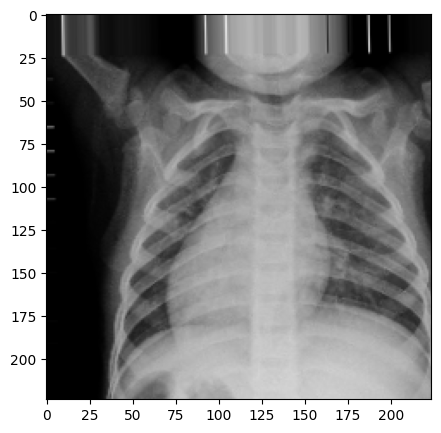

In [9]:
%matplotlib inline
print(np.asarray(testX[0]).shape)
plt.imshow(np.asarray(testX[0]))

In [10]:
datagen_val_test = ImageDataGenerator(
width_shift_range=0.9, height_shift_range=0.9)
#X_train = X_train.reshape(5216, 224, 224,1)
datagen_val.fit(X_val)
train_gen_val_test = datagen_val.flow(X_val)


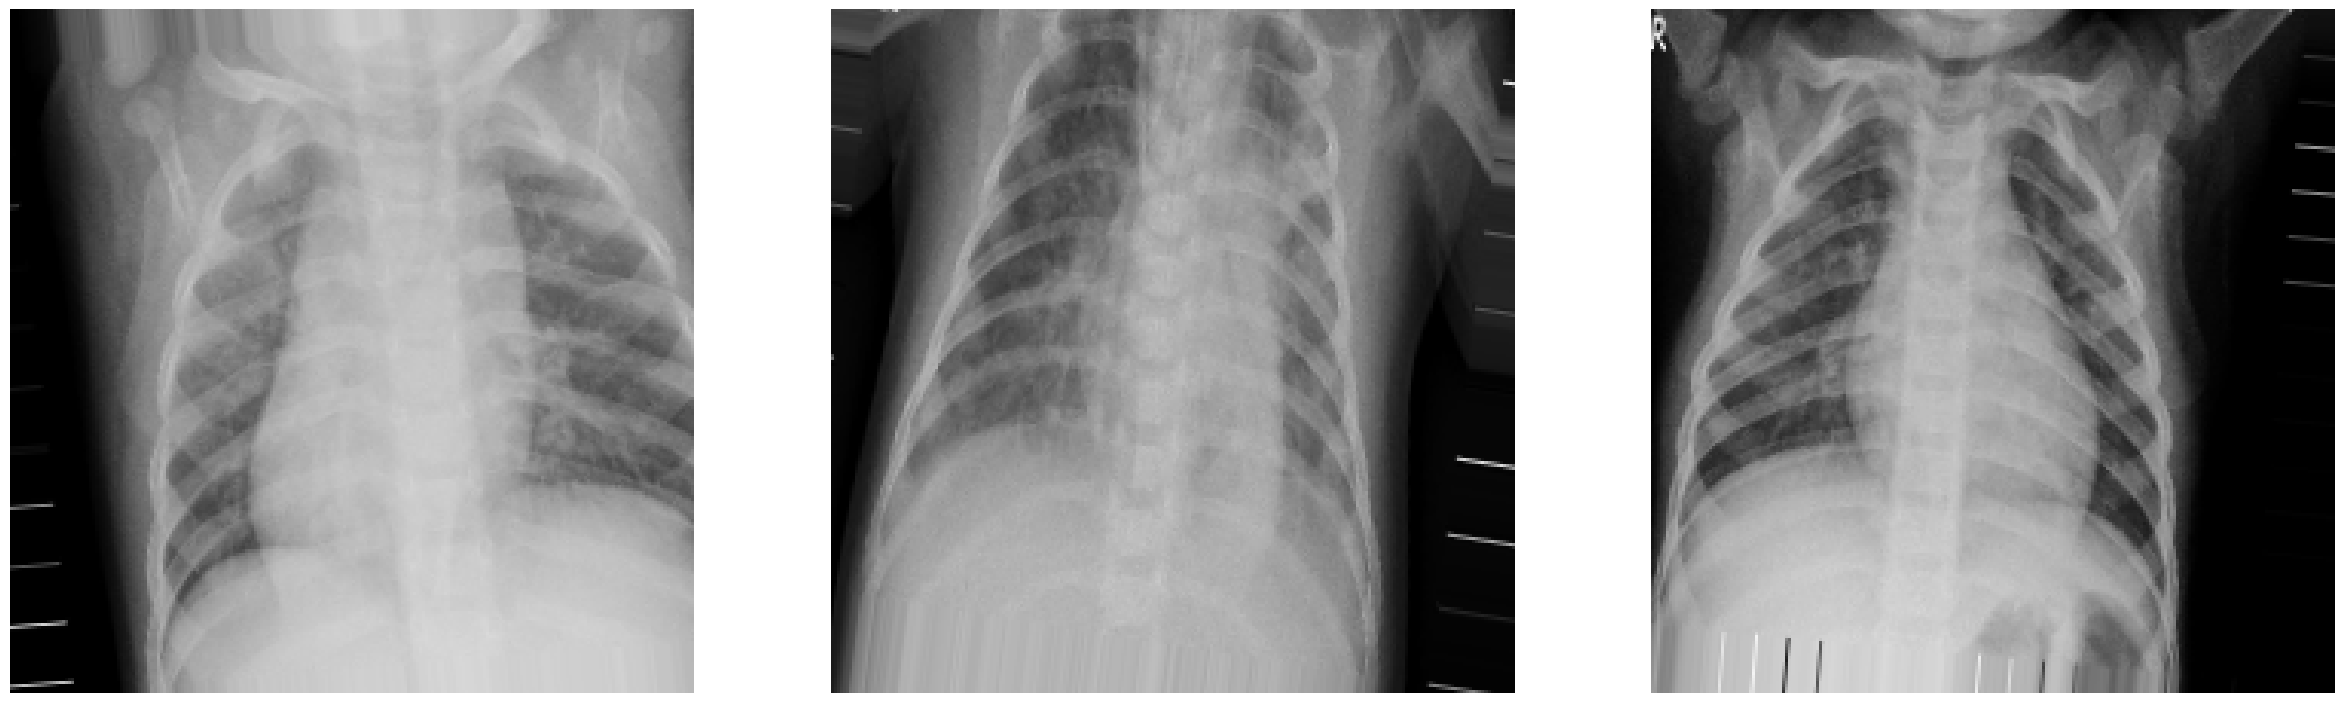

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,30))
# generate batch of images
#data = im.fromarray(testX[0])
for i in range(3):
# convert to unsigned integers
    testX = next(train_gen_val_test)
    image = testX[0].astype('uint8')
# plot image
    ax[i].imshow(np.asarray(testX[0]))
    #ax[i].imshow(image)
    ax[i].axis('off')

In [27]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)
X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)


In [77]:
def model(input_shape:tuple=(224,224,3), classes=1, initializer=glorot_uniform):
    
    #Input Layer with shape (224,224,3)
    input = Input(input_shape)
    
    #first CNN block
    X = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation = 'relu',kernel_initializer = 'glorot_uniform')(input)
    X = BatchNormalization()(X)
    X = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation = 'relu',kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2,2))(X)
    
    #Second CNN block
    X = Conv2D(filters=32, kernel_size=(3,3), padding='same',activation = 'relu',kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization()(X)
    X = Conv2D(filters=32, kernel_size=(3,3), padding='same',activation = 'relu',kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2,2))(X)
    
    #Third CNN block
    X = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation = 'relu',kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization()(X)
    X = Conv2D(filters=64, kernel_size=(3,3), padding='same',activation = 'relu',kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2,2))(X)
    
    #Fourth CNN block
    X = Conv2D(filters=96, kernel_size=(3,3), padding='same',activation = 'relu',kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization()(X)
    X = Conv2D(filters=96, kernel_size=(3,3), padding='same',activation = 'relu',kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2,2))(X)
    
    #Fifth CNN block
    X = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation = 'relu',kernel_initializer = 'glorot_uniform')(X) 
    X = BatchNormalization()(X)
    X = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation = 'relu',kernel_initializer = 'glorot_uniform')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2,2))(X)
    
    #Dense Layers for Classification purpose
    X = Flatten()(X)
    X = Dense(units=2048, activation='relu')(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(units=1024, activation='relu')(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(units=512, activation='relu')(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(units=256, activation='relu')(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(units=128, activation='relu')(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(units=64, activation='relu')(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(units=32, activation='relu')(X)
    X = Dropout(rate=0.3)(X)
    
    #Output Layer with sigmoid activation
    output = Dense(classes, activation='sigmoid', kernel_initializer = 'glorot_uniform')(X)
    model = Model(inputs = input, outputs = output)
    return model

In [78]:
GNet = model(input_shape=(224,224,3), initializer=glorot_uniform)
GNet.summary()
GNet.layers


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_220 (Conv2D)         (None, 224, 224, 16)      448       
                                                                 
 batch_normalization_220 (Ba  (None, 224, 224, 16)     64        
 tchNormalization)                                               
                                                                 
 conv2d_221 (Conv2D)         (None, 224, 224, 16)      2320      
                                                                 
 batch_normalization_221 (Ba  (None, 224, 224, 16)     64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_110 (MaxPooli  (None, 112, 112, 16)     0  

In [79]:
GNet1 = model(input_shape=(224,224,3), initializer=glorot_uniform)
GNet2 = model(input_shape=(224,224,3), initializer=glorot_uniform)
GNet3 = model(input_shape=(224,224,3), initializer=glorot_uniform)
GNet4 = model(input_shape=(224,224,3), initializer=glorot_uniform)

In [80]:
# Define the optimizer and other hyperparameters and metrics and compile the model
BATCH_SIZE = 32
EPOCHS = 65
epochs1 = 25
epcohs2 = 35
epochs3 = 50
epochs4 = 60

optimizer = Adam(learning_rate=0.0001, decay=1e-5)

GNet.compile(loss='binary_crossentropy', metrics=['accuracy','mse'], optimizer=optimizer)

In [81]:
GNet1.compile(loss='binary_crossentropy', metrics=['accuracy','mse'], optimizer=optimizer)
GNet2.compile(loss='binary_crossentropy', metrics=['accuracy','mse'], optimizer=optimizer)
GNet3.compile(loss='binary_crossentropy', metrics=['accuracy','mse'], optimizer=optimizer)
GNet4.compile(loss='binary_crossentropy', metrics=['accuracy','mse'], optimizer=optimizer)

In [82]:
num_training_steps = X_train.shape[0]//BATCH_SIZE
num_validation_steps = len(X_val)
print("Number of training steps: ", num_training_steps)
print("Number of validation steps: ", num_validation_steps)
print(testX.shape,testY.shape,train_gen_val)

Number of training steps:  163
Number of validation steps:  16
(16, 224, 224, 3) (16, 1) <keras.preprocessing.image.NumpyArrayIterator object at 0x295599d30>


In [83]:
history1 = GNet1.fit_generator(train_gen, 
    epochs = epochs1, 
    #batch_size = BATCH_SIZE,
    steps_per_epoch = num_training_steps,
    validation_data = train_gen_val,
    )

Epoch 1/25


/var/folders/by/vpx1dnsx5pg90s24q6mbhmmw0000gn/T/ipykernel_15619/3534719155.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = GNet1.fit_generator(train_gen,


163/163 [==============================] - 29s 166ms/step - loss: 0.3560 - accuracy: 0.8411 - mse: 0.1131 - val_loss: 1.7094 - val_accuracy: 0.5000 - val_mse: 0.4672
Epoch 2/25
163/163 [==============================] - 26s 160ms/step - loss: 0.2230 - accuracy: 0.9149 - mse: 0.0646 - val_loss: 2.4860 - val_accuracy: 0.5000 - val_mse: 0.4921
Epoch 3/25
163/163 [==============================] - 27s 165ms/step - loss: 0.1839 - accuracy: 0.9256 - mse: 0.0539 - val_loss: 1.6392 - val_accuracy: 0.5000 - val_mse: 0.4506
Epoch 4/25
163/163 [==============================] - 26s 160ms/step - loss: 0.1482 - accuracy: 0.9473 - mse: 0.0425 - val_loss: 0.4177 - val_accuracy: 0.8750 - val_mse: 0.1257
Epoch 5/25
163/163 [==============================] - 26s 161ms/step - loss: 0.1237 - accuracy: 0.9532 - mse: 0.0354 - val_loss: 1.6698 - val_accuracy: 0.5625 - val_mse: 0.3903
Epoch 6/25
163/163 [==============================] - 26s 158ms/step - loss: 0.1193 - accuracy: 0.9542 - mse: 0.0341 - val_los

In [85]:
history2= GNet2.fit_generator(train_gen, 
    epochs = epcohs2, 
    #batch_size = BATCH_SIZE,
    steps_per_epoch = num_training_steps,
    validation_data = train_gen_val,
    )

/var/folders/by/vpx1dnsx5pg90s24q6mbhmmw0000gn/T/ipykernel_15619/4276197072.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2= GNet2.fit_generator(train_gen,


Epoch 1/35
163/163 [==============================] - 28s 163ms/step - loss: 0.3566 - accuracy: 0.8493 - mse: 0.1082 - val_loss: 5.6496 - val_accuracy: 0.5000 - val_mse: 0.5000
Epoch 2/35
163/163 [==============================] - 27s 162ms/step - loss: 0.2090 - accuracy: 0.9181 - mse: 0.0600 - val_loss: 2.0007 - val_accuracy: 0.5000 - val_mse: 0.4745
Epoch 3/35
163/163 [==============================] - 27s 163ms/step - loss: 0.1555 - accuracy: 0.9438 - mse: 0.0430 - val_loss: 1.4282 - val_accuracy: 0.5000 - val_mse: 0.3924
Epoch 4/35
163/163 [==============================] - 26s 159ms/step - loss: 0.1354 - accuracy: 0.9511 - mse: 0.0377 - val_loss: 0.8292 - val_accuracy: 0.5000 - val_mse: 0.3124
Epoch 5/35
163/163 [==============================] - 26s 160ms/step - loss: 0.1252 - accuracy: 0.9507 - mse: 0.0362 - val_loss: 0.8171 - val_accuracy: 0.7500 - val_mse: 0.2411
Epoch 6/35
163/163 [==============================] - 26s 160ms/step - loss: 0.1096 - accuracy: 0.9586 - mse: 0.031

In [86]:
history3 = GNet3.fit_generator(train_gen, 
    epochs = epochs3, 
    #batch_size = BATCH_SIZE,
    steps_per_epoch = num_training_steps,
    validation_data = train_gen_val,
    )

Epoch 1/50


/var/folders/by/vpx1dnsx5pg90s24q6mbhmmw0000gn/T/ipykernel_15619/1354370204.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = GNet3.fit_generator(train_gen,


163/163 [==============================] - 28s 162ms/step - loss: 0.4444 - accuracy: 0.8129 - mse: 0.1332 - val_loss: 2.7784 - val_accuracy: 0.5000 - val_mse: 0.4961
Epoch 2/50
163/163 [==============================] - 26s 159ms/step - loss: 0.2132 - accuracy: 0.9158 - mse: 0.0619 - val_loss: 4.3614 - val_accuracy: 0.5000 - val_mse: 0.4997
Epoch 3/50
163/163 [==============================] - 26s 158ms/step - loss: 0.1570 - accuracy: 0.9415 - mse: 0.0447 - val_loss: 1.7552 - val_accuracy: 0.5000 - val_mse: 0.4187
Epoch 4/50
163/163 [==============================] - 26s 158ms/step - loss: 0.1384 - accuracy: 0.9496 - mse: 0.0387 - val_loss: 2.7416 - val_accuracy: 0.5000 - val_mse: 0.4604
Epoch 5/50
163/163 [==============================] - 26s 158ms/step - loss: 0.1282 - accuracy: 0.9559 - mse: 0.0353 - val_loss: 0.7252 - val_accuracy: 0.5625 - val_mse: 0.2660
Epoch 6/50
163/163 [==============================] - 26s 157ms/step - loss: 0.1224 - accuracy: 0.9549 - mse: 0.0343 - val_los

In [87]:
history4 = GNet4.fit_generator(train_gen, 
    epochs = epochs4, 
    #batch_size = BATCH_SIZE,
    steps_per_epoch = num_training_steps,
    validation_data = train_gen_val,
    )

Epoch 1/60


/var/folders/by/vpx1dnsx5pg90s24q6mbhmmw0000gn/T/ipykernel_15619/1330033358.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4 = GNet4.fit_generator(train_gen,


163/163 [==============================] - 28s 162ms/step - loss: 0.3854 - accuracy: 0.8282 - mse: 0.1187 - val_loss: 2.7205 - val_accuracy: 0.5000 - val_mse: 0.4956
Epoch 2/60
163/163 [==============================] - 27s 162ms/step - loss: 0.2299 - accuracy: 0.9032 - mse: 0.0703 - val_loss: 3.3034 - val_accuracy: 0.5000 - val_mse: 0.4980
Epoch 3/60
163/163 [==============================] - 26s 159ms/step - loss: 0.1736 - accuracy: 0.9348 - mse: 0.0501 - val_loss: 1.6340 - val_accuracy: 0.5000 - val_mse: 0.4336
Epoch 4/60
163/163 [==============================] - 26s 158ms/step - loss: 0.1403 - accuracy: 0.9526 - mse: 0.0380 - val_loss: 0.8422 - val_accuracy: 0.6875 - val_mse: 0.2785
Epoch 5/60
163/163 [==============================] - 26s 161ms/step - loss: 0.1264 - accuracy: 0.9534 - mse: 0.0360 - val_loss: 0.8963 - val_accuracy: 0.6250 - val_mse: 0.3139
Epoch 6/60
163/163 [==============================] - 26s 158ms/step - loss: 0.1129 - accuracy: 0.9582 - mse: 0.0320 - val_los

In [59]:
#(X_val, y_val)
history = GNet.fit_generator(train_gen, 
    epochs = EPOCHS, 
    #batch_size = BATCH_SIZE,
    steps_per_epoch = num_training_steps,
    validation_data = train_gen_val,
    #callbacks = [checkpoint]
    #callbacks = [early_stopping,checkpoint]
    )

Epoch 1/65


/var/folders/by/vpx1dnsx5pg90s24q6mbhmmw0000gn/T/ipykernel_15619/1585144914.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = GNet.fit_generator(train_gen,


163/163 [==============================] - 28s 159ms/step - loss: 0.4046 - accuracy: 0.8115 - mse: 0.1312 - val_loss: 1.2761 - val_accuracy: 0.5000 - val_mse: 0.4217
Epoch 2/65
163/163 [==============================] - 25s 152ms/step - loss: 0.2626 - accuracy: 0.8901 - mse: 0.0796 - val_loss: 1.2292 - val_accuracy: 0.5000 - val_mse: 0.3989
Epoch 3/65
163/163 [==============================] - 25s 153ms/step - loss: 0.2043 - accuracy: 0.9208 - mse: 0.0606 - val_loss: 1.3925 - val_accuracy: 0.5000 - val_mse: 0.4342
Epoch 4/65
163/163 [==============================] - 25s 152ms/step - loss: 0.1631 - accuracy: 0.9363 - mse: 0.0470 - val_loss: 1.9895 - val_accuracy: 0.5000 - val_mse: 0.4576
Epoch 5/65
163/163 [==============================] - 25s 155ms/step - loss: 0.1469 - accuracy: 0.9448 - mse: 0.0417 - val_loss: 0.8115 - val_accuracy: 0.6250 - val_mse: 0.2604
Epoch 6/65
163/163 [==============================] - 25s 153ms/step - loss: 0.1377 - accuracy: 0.9482 - mse: 0.0391 - val_los

In [60]:
# Evaluation on the test set
test_loss, test_score, mse = GNet.evaluate(
    X_test, 
    y_test, 
    batch_size=BATCH_SIZE)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)


20/20 [==============================] - 1s 46ms/step - loss: 0.2786 - accuracy: 0.8862 - mse: 0.0829
Loss on test set:  0.278598815202713
Accuracy on test set:  0.8862179517745972


In [88]:
test_loss1, test_score1, mse1 = GNet1.evaluate(
    X_test, 
    y_test, 
    batch_size=BATCH_SIZE)
print("Loss on test set on model 1: ", test_loss1)
print("Accuracy on test set model 1: ", test_score1)
print("MSE loss on test set model 1: ", mse1)

20/20 [==============================] - 2s 62ms/step - loss: 0.5246 - accuracy: 0.8718 - mse: 0.1073
Loss on test set on model 1:  0.5245600342750549
Accuracy on test set model 1:  0.8717948794364929
MSE loss on test set model 1:  0.10731399804353714


In [89]:
test_loss2, test_score2, mse2 = GNet2.evaluate(
    X_test, 
    y_test, 
    batch_size=BATCH_SIZE)
print("Loss on test set on model 2: ", test_loss2)
print("Accuracy on test set model 2: ", test_score2)
print("MSE loss on test set model 2: ", mse2)

20/20 [==============================] - 2s 64ms/step - loss: 0.7833 - accuracy: 0.7244 - mse: 0.2099
Loss on test set on model 2:  0.7832528948783875
Accuracy on test set model 2:  0.7243589758872986
MSE loss on test set model 2:  0.20989322662353516


In [90]:
test_loss3, test_score3, mse3 = GNet3.evaluate(
    X_test, 
    y_test, 
    batch_size=BATCH_SIZE)
print("Loss on test set on model 3: ", test_loss3)
print("Accuracy on test set model 3: ", test_score3)
print("MSE loss on test set model 3: ", mse3)

20/20 [==============================] - 2s 59ms/step - loss: 0.2637 - accuracy: 0.9151 - mse: 0.0691
Loss on test set on model 3:  0.2636863589286804
Accuracy on test set model 3:  0.9150640964508057
MSE loss on test set model 3:  0.06910588592290878


In [91]:
test_loss4, test_score4, mse4 = GNet4.evaluate(
    X_test, 
    y_test, 
    batch_size=BATCH_SIZE)
print("Loss on test set on model 4: ", test_loss4)
print("Accuracy on test set model 4: ", test_score4)
print("MSE loss on test set model 4: ", mse4)

20/20 [==============================] - 2s 68ms/step - loss: 0.2455 - accuracy: 0.8942 - mse: 0.0728
Loss on test set on model 4:  0.2455369234085083
Accuracy on test set model 4:  0.8942307829856873
MSE loss on test set model 4:  0.07278136909008026


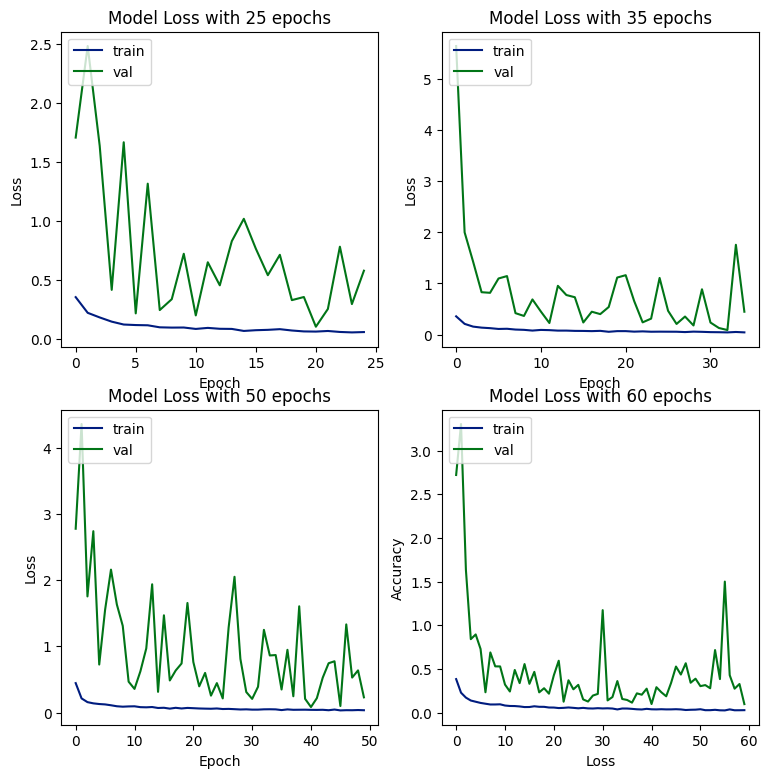

In [103]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9))
# generate batch of images
#data = im.fromarray(testX[0])
for i in range(4):
# convert to unsigned integers
# plot image
    if(i==0):
        ax[i][i].plot(history1.history['loss'])
        ax[i][i].plot(history1.history['val_loss'])
        ax[i][i].set_title('Model Loss with 25 epochs')
        ax[i][i].set_ylabel('Loss')
        ax[i][i].set_xlabel('Epoch')
        ax[i][i].legend(['train', 'val'], loc='upper left')
        #fig[i][i].show()
    if(i==1):
        ax[0][i].plot(history2.history['loss'])
        ax[0][i].plot(history2.history['val_loss'])
        ax[0][i].set_title('Model Loss with 35 epochs')
        ax[0][i].set_ylabel('Loss')
        ax[0][i].set_xlabel('Epoch')
        ax[0][i].legend(['train', 'val'], loc='upper left')
        #fig[i][i].show()
    if(i==2):
        ax[1][0].plot(history3.history['loss'])
        ax[1][0].plot(history3.history['val_loss'])
        ax[1][0].set_title('Model Loss with 50 epochs')
        ax[1][0].set_ylabel('Loss')
        ax[1][0].set_xlabel('Epoch')
        ax[1][0].legend(['train', 'val'], loc='upper left')
        #fig[i][i].show()
    if(i==3):
        ax[1][1].plot(history4.history['loss'])
        ax[1][1].plot(history4.history['val_loss'])
        ax[1][1].set_title('Model Loss with 60 epochs')
        ax[1][1].set_ylabel('Accuracy')
        ax[1][1].set_xlabel('Loss')
        ax[1][1].legend(['train', 'val'], loc='upper left')
        #fig[i][i].show()

In [ ]:
#Saving the model for our future use cases
GNet.save('PneuCNN.h5')

In [5]:
GNet5=load_model('PneuCNN.h5')
GNet5.summary()

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2

In [ ]:
# Lets plot the model's history including the confusion matrix

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(test_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

y_pred = GNet.predict(X_test)
#print(y_pred)
y_pred = (y_pred > 0.5)
classnames = ["Normal" , "Pneumonia"]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix ')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



#classification report 
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
def testOnSample(model, path):
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    X = np.expand_dims(img, axis=0)
    X = np.array(X)
    X = tf.convert_to_tensor(X)

    y = model.predict(X, batch_size = 32)
    print(y)
    file_name = os.path.basename(path)
    if y[0]> 0.5:
        print("The file name: " + file_name + ' has pneumonia with {} probability'.format(y[0]))
        plt.imshow(img)
    else:
        print("the file name: " + file_name + ' is normal with {} probability'.format(1-y[0]))
        plt.imshow(img)

In [ ]:
testOnSample(model = GNet, path = 'samples/S1_normal.jpeg')

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(GNet,"/users/gauravdhanuka/documents/design project/model/savedmodel")

In [98]:
y_pred = GNet3.predict(X_test)
y_pred = (y_pred > 0.5)
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
## Accuracy
accuracyy = accuracy_score(y_test,y_pred)

## Precision
print(precision_score(y_test,y_pred))
## Recall
print(recall_score(y_test,y_pred))
## F1 Score
print(f1_score(y_test,y_pred))




# Calculate Precision and Recall
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_Score = 2*((precision*recall)/(precision + recall))
specificity = tn / (tn+fp)
print("Accuracy of the model is {:.3f}".format(accuracyy))
print("Recall of the model is {:.3f}".format(recall))
print("Precision of the model is {:.3f}".format(precision))
print("F1-Score of the model is {:.3f}".format(f1_Score))
print("Specificty of the model is {:.3f}".format(specificity))


20/20 [==============================] - 1s 46ms/step
0.924433249370277
0.941025641025641
0.9326556543837357
Accuracy of the model is 0.915
Recall of the model is 0.941
Precision of the model is 0.924
F1-Score of the model is 0.933
Specificty of the model is 0.872


In [105]:
y_pred = GNet5.predict(X_test)
y_pred = (y_pred > 0.5)
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
## Accuracy
print(accuracy_score(y_test,y_pred))

## Precision
print(precision_score(y_test,y_pred))
## Recall
print(recall_score(y_test,y_pred))
## F1 Score
print(f1_score(y_test,y_pred))




# Calculate Precision and Recall
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_Score = 2*((precision*recall)/(precision + recall))
specificity = tn / (tn+fp)
print("Accuracy of the model is {:.3f}".format(accuracyy))
print("Recall of the model is {:.3f}".format(recall))
print("Precision of the model is {:.3f}".format(precision))
print("F1-Score of the model is {:.3f}".format(f1_Score))
print("Specificty of the model is {:.3f}".format(specificity))


20/20 [==============================] - 1s 47ms/step
0.9150641025641025
0.914004914004914
0.9538461538461539
0.9335006273525723
Accuracy of the model is 0.915
Recall of the model is 0.954
Precision of the model is 0.914
F1-Score of the model is 0.934
Specificty of the model is 0.850


In [ ]:
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor = 'val_accuracy', mode = "max", save_best_only=True, save_weights_only=True)

In [1]:
from keras.utils.vis_utils import plot_model

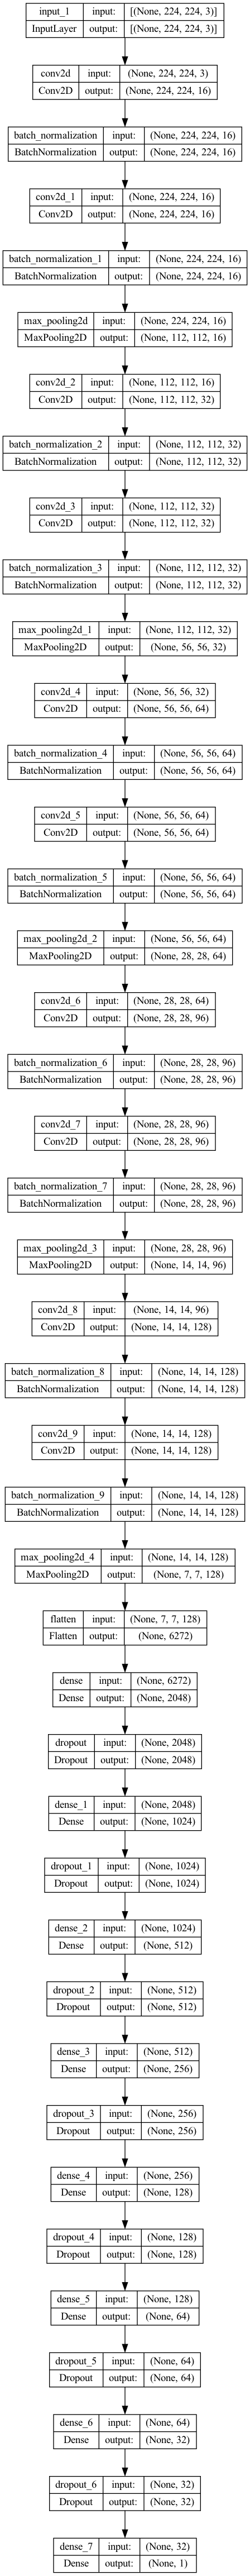

In [6]:
plot_model(GNet5, to_file='model_plot.png', show_shapes=True, show_layer_names=True)